# LDA

In [ ]:
import nltk
from nltk import FreqDist
# nltk.download('stopwords') # run this one time

import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
chiRest = []
with open("Chinese_restaurant.json", encoding = "utf-8") as f:
     for line in f:
        chiRest.append(json.loads(line))

In [49]:
chiRest_df = pd.DataFrame(chiRest)
chiRest_df.head()

,Review,Tip,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"[{'stars': 3.0, 'cool': 0, 'date': '2017-01-27 21:54:30', 'text': 'My girlfriend and I went for dinner at Emerald Chinese after a Thursday night workout. We arrived around 7:30pm and were seated ...","[{'text': 'Spring & egg rolls are great, get them with extra plum sauce!', 'date': '2016-08-08 01:48:14', 'user_id': 'fENhF1F6I9c2ssnkfprYzw', 'business_id': 'QXAEGFB4oINsVuTFxEYKFQ', 'compliment_...",30 Eglinton Avenue W,"{'Ambience': '{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}', 'RestaurantsAttire':...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood",Mississauga,"{'Tuesday': '9:0-0:0', 'Sunday': '9:0-0:0', 'Thursday': '9:0-0:0', 'Saturday': '9:0-1:0', 'Wednesday': '9:0-0:0', 'Monday': '9:0-0:0', 'Friday': '9:0-1:0'}",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
1,"[{'stars': 1.0, 'cool': 0, 'date': '2012-10-11 23:28:11', 'text': 'this restaurant doesnt exist anymore...new owner under new name.', 'user_id': 'OpLYM_y6ReDz6dEv8_ra4A', 'review_id': 'rqOrfmD7bgz...",NaN,2825 32 Avenue NE,"{'RestaurantsAttire': 'u'casual'', 'RestaurantsPriceRange2': '1', 'RestaurantsDelivery': 'False', 'RestaurantsTakeOut': 'True', 'GoodForKids': 'True', 'OutdoorSeating': 'False', 'RestaurantsGoodFo...",e_EMySqP0uwlVZfd8mRaaQ,"Chinese, Dim Sum, Restaurants",Calgary,None,0,51.081162,-113.993474,Pearl Garden,T1Y,4,2.0,AB
2,"[{'stars': 4.0, 'cool': 1, 'date': '2012-04-28 21:08:22', 'text': 'Enjoyed Nee House immensely. No service issues, just fantastic chinese food. Food order? Spicy Green Beans = Perfect!, Chow Fun (...","[{'text': 'Pretty busy tonight!', 'date': '2011-10-02 03:12:41', 'user_id': 'MTfbkOQvNx-g4xpFExusNA', 'business_id': '44YFU284Z3KDEy25QyVoUw', 'compliment_count': 0}, {'text': 'The best Hot and So...","13843 N Tatum Blvd, Ste 15","{'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}', 'RestaurantsAttire':...",44YFU284Z3KDEy25QyVoUw,"Chinese, Restaurants",Phoenix,"{'Tuesday': '11:0-21:0', 'Sunday': '11:0-21:30', 'Thursday': '11:0-21:0', 'Saturday': '11:0-21:30', 'Wednesday': '11:0-21:0', 'Monday': '11:0-21:0', 'Friday': '11:0-21:30'}",1,33.613020,-111.977036,Nee House Chinese Restaurant,85032,269,3.5,AZ
3,"[{'stars': 2.0, 'cool': 1, 'date': '2008-05-15 01:26:07', 'text': 'It was our first night/ day in Vegas. Kinda hard to tell what time of day it was. We were hungry, dazed, and delirious. Not sure...",[{'text': 'Hate this placeee the sushi seems it has been sitting there for days only thing i like is the fried rice there jello has gotten the life sucked out of it not much good food to choose fr...,4343 N Rancho Dr,None,X8mtoSxY8whtmbDlj0D3Aw,"Restaurants, Chinese",Las Vegas,None,1,36.238596,-115.233331,Imperial Asian Buffet,89030,4,2.0,NV
4,"[{'stars': 2.0, 'cool': 0, 'date': '2018-08-14 03:54:09', 'text': 'Fried Rice - Tasteless, Tasteless Chicken Wings - Dry, Dry Pot Stickers - Doughy, Doughy Yummy, Yummy - Isn't, Isn't', 'user_id':...","[{'text': 'Waited for my order to go as I listen to all the shouting in the kitchen!', 'date': '2016-11-21 19:12:19', 'user_id': 'V74paj6Zok4DvGnciFEZMg', 'business_id': 'MhnihE0alud0ereVInSt8Q', ...","2765 N Scottsdale Rd, Ste 105","{'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': True, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}', 'RestaurantsAttire':...",MhnihE0alud0ereVInSt8Q,"Chinese, Restaurants",Scottsdale,"{'Tuesday': '11:0-21:30', 'Sunday': '11:0-21:30', 'Thursday': '11:0-21:30', 'Saturday': '11:0-22:0', 'Wednesday': '11:0-21:30', 'Monday': '11:0-21:30', 'Frida

In [79]:
chiReview = pd.read_csv("Chinese_review.csv", encoding = "utf-8")

In [80]:
chiReview.head(10)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,business_index,business_id,cool,date,funny,review_id,stars,text,useful,user_id,text_token,text_length,bigram,trigram,bigram_length,trigram_length
0,0,0,0,0,QXAEGFB4oINsVuTFxEYKFQ,0,2017-01-27 21:54:30,2,6W0MQHmasK0IsaoDo4bmkw,3.0,My girlfriend and I went for dinner at Emerald Chinese after a Thursday night workout.\r\r\r\n\r\r\r\nWe arrived around 7:30pm and were seated after a short wait. After browsing the menu and a br...,3,2K62MJ4CJ19L8Tp5pRfjfQ,"['girlfriend', 'went', 'dinner', 'emerald', 'chinese', 'thursday', 'night', 'workout', 'arrived', 'around', '7:30pm', 'seated', 'short', 'wait', 'browsing', 'menu', 'brief', 'discussion', 'waiter'...",241,"[('emerald', 'chinese'), ('thursday', 'night'), ('night', 'workout'), ('arrived', 'around'), ('around', '7'), ('7', '30pm'), ('short', 'wait'), ('brief', 'discussion'), ('ordered', 'seafood'), ('s...","[('emerald', 'chinese', 'after'), ('thursday', 'night', 'workout'), ('night', 'workout', 'we'), ('arrived', 'around', '7'), ('around', '7', '30pm'), ('7', '30pm', 'and'), ('short', 'wait', 'after'...",79,78
1,1,1,1,0,QXAEGFB4oINsVuTFxEYKFQ,0,2013-06-24 23:11:30,0,BeeBfUxvzD4qNX4HxrgA5g,3.0,We've always been there on a Sunday so we were hoping that Saturday dim sum would be less busy. No such luck. We were surprised that some of the dishes were cold because it was so packed; I could ...,0,A0kENtCCoVT3m7T35zb2Vg,"['always', 'sunday', 'hoping', 'saturday', 'dim', 'sum', 'would', 'less', 'busy', 'no', 'luck', 'surprised', 'dishes', 'cold', 'packed', 'could', 'understand', 'empty', 'carts', 'not', 'circulatin...",86,"[(""we've"", 'always'), ('saturday', 'dim'), ('dim', 'sum'), ('sum', 'would'), ('less', 'busy'), ('busy', 'no'), ('could', 'understand'), ('every', 'table'), ('get', 'drinks'), ('items', 'napkins')]","[(""we've"", 'always', 'been'), ('saturday', 'dim', 'sum'), ('dim', 'sum', 'would'), ('sum', 'would', 'be'), ('less', 'busy', 'no'), ('busy', 'no', 'such'), ('could', 'understand', 'if'), ('every', ...",10,10
2,2,2,2,0,QXAEGFB4oINsVuTFxEYKFQ,0,2016-01-04 12:59:22,0,A1D2kUnZ0HTroFreAheNSg,3.0,"***No automatic doors, not baby friendly!*** I frequent this Chinese restaurant before and post partum. Dim sum is ok, dishes at dinner time are huge, service is great, BUT there are no automatic ...",0,SuOLY03LW5ZcnynKhbTydA,"['***no', 'automatic', 'doors', 'not', 'baby', 'friendly', '***', 'frequent', 'chinese', 'restaurant', 'post', 'partum', 'dim', 'sum', 'ok', 'dishes', 'dinner', 'time', 'huge', 'service', 'great',...",44,"[('no', 'automatic'), ('automatic', 'doors'), ('doors', 'not'), ('not', 'baby'), ('baby', 'friendly'), ('chinese', 'restaurant'), ('post', 'partum'), ('partum', 'dim'), ('dim', 'sum'), ('ok', 'dis...","[('no', 'automatic', 'doors'), ('automatic', 'doors', 'not'), ('doors', 'not', 'baby'), ('not', 'baby', 'friendly'), ('baby', 'friendly', 'i'), ('chinese', 'restaurant', 'before'), ('post', 'partu...",15,14
3,3,3,3,0,QXAEGFB4oINsVuTFxEYKFQ,0,2014-05-09 02:38:43,0,2pf45Stf-pNew-xgTababQ,1.0,"Horrible service,\r\r\r\nI went there tonight with my boyfriend because he;s passed by the place a couple of times and we wanted to try it out. We orders bok choy, chicken fried rice and some lemo...",1,lymyUak6KNcNKoDbK87MiQ,"['horrible', 'service', 'went', 'tonight', 'boyfriend', 'passed', 'place', 'couple', 'times', 'wanted', 'try', 'orders', 'bok', 'choy', 'chicken', 'fried', 'rice', 'lemon', 'chicken', 'got', 'food...",223,"[('horrible', 'service'), ('orders', 'bok'), ('bok', 'choy'), ('choy', 'chicken'), ('chicken', 'fried'), ('fried', 'rice'), ('lemon', 'chicken'), ('looked', 'old'), ('old', 'like'), ('even', 'ackn...","[('horrible', 'service', 'i'), ('orders', 'bok', 'choy'), ('bok', 'choy', 'chicken'), ('choy', 'chicken', 'fried'), ('chicken', 'fried', 'rice'), ('fried', 'rice', 'and'), ('lemon', 'chicken', 'wh...",40,39
4,4,4,4,0,QXAEGFB4oINsVuTFxEYKFQ,2,2011-03-21 14:39:55,1,RHhlmL07evgAdPaXQV8Omg,4.0,One of the gauges of a good 

In [19]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

 # select top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

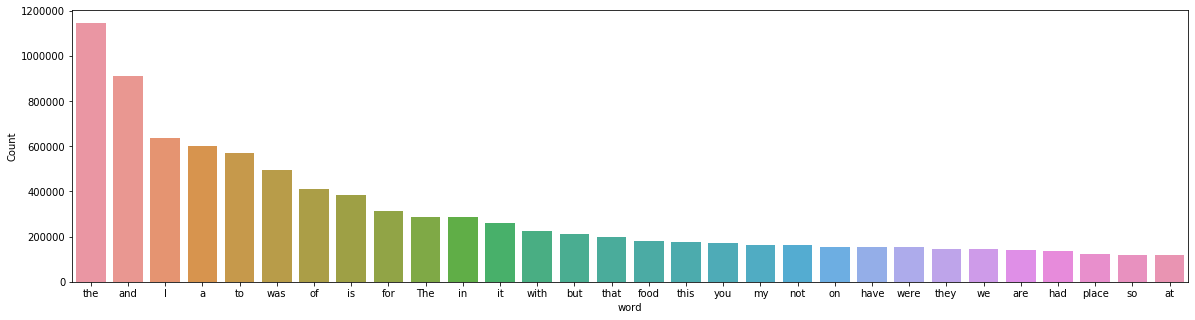

In [61]:
freq_words(chiReview['text']) 

In [62]:
# remove unwanted characters, numbers and symbols
chiReview["reviews_token"] = chiReview['text'].str.replace("[^a-zA-Z#]", " ")

In [63]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
chiReview["reviews_token"] = chiReview["reviews_token"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in chiReview["reviews_token"]]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [28]:
# !python -m spacy download en # one time run

     |████████████████████████████████| 12.0MB 1.8MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-cp37-none-any.whl size=12019126 sha256=4c82f7df841d222f1255e876c70560fa50eac69870611a5d644ff5a090e5a176
  Stored in directory: /private/var/folders/7b/15d51_w93kj1th_gc7dsjmjw0000gn/T/pip-ephem-wheel-cache-7j4nkluq/wheels/48/5c/1c/15f9d02afc8221a668d2172446dd8467b20cdb9aef80a172a4
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/hewishwang/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/hewishwang/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [29]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [64]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['always', 'sunday', 'hoping', 'saturday', 'dim', 'sum', 'would', 'less', 'busy', 'luck', 'surprised', 'dishes', 'cold', 'packed', 'could', 'understand', 'empty', 'carts', 'circulating', 'every', 'table', 'full', 'took', 'get', 'drinks', 'items', 'napkins', 'the', 'dishes', 'quality', 'visits', 'acceptable']


In [31]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['busy', 'luck', 'surprised', 'dish', 'cold', 'packed', 'empty', 'cart', 'table', 'full', 'get', 'drink', 'item', 'dish', 'quality', 'visit', 'acceptable']


In [66]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

chiReview["reviews_token"] = reviews_3


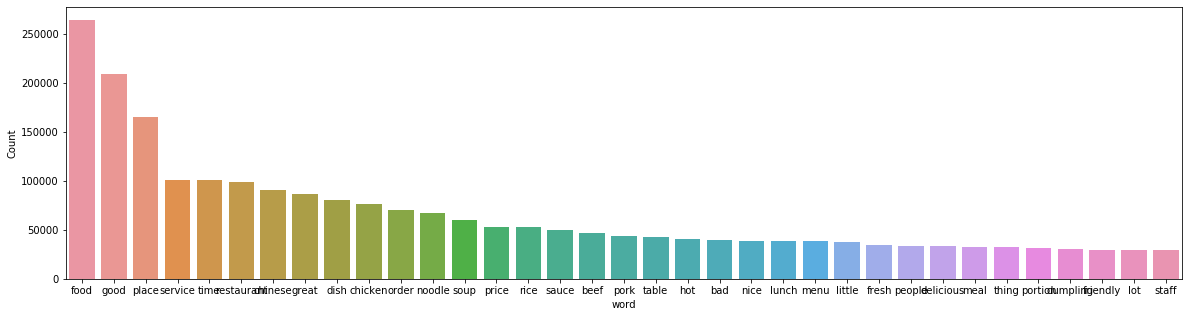

In [67]:
freq_words(chiReview["reviews_token"], 35) 

In [40]:
dictionary = corpora.Dictionary(reviews_2) 

In [41]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                                   id2word=dictionary,
                                   num_topics=7, 
                                   random_state=100,
                                   chunksize=1000,
                                   passes=50)

In [42]:
lda_model.print_topics() 

[(0,
  '0.093*"food" + 0.059*"great" + 0.057*"good" + 0.048*"place" + 0.041*"service" + 0.033*"chinese" + 0.025*"restaurant" + 0.024*"friendly" + 0.018*"time" + 0.017*"delicious"'),
 (1,
  '0.052*"chicken" + 0.036*"sauce" + 0.033*"rice" + 0.031*"good" + 0.027*"soup" + 0.023*"beef" + 0.017*"dish" + 0.016*"egg" + 0.015*"hot" + 0.015*"spicy"'),
 (2,
  '0.038*"noodle" + 0.034*"dish" + 0.027*"restaurant" + 0.021*"place" + 0.019*"soup" + 0.017*"good" + 0.012*"menu" + 0.012*"beef" + 0.012*"chinese" + 0.009*"hot"'),
 (3,
  '0.073*"good" + 0.069*"food" + 0.064*"price" + 0.060*"lunch" + 0.043*"place" + 0.039*"portion" + 0.026*"special" + 0.024*"chinese" + 0.021*"cheap" + 0.019*"service"'),
 (4,
  '0.075*"dumpling" + 0.065*"pork" + 0.033*"lobster" + 0.031*"duck" + 0.028*"fish" + 0.021*"tea" + 0.020*"good" + 0.020*"bun" + 0.014*"milk" + 0.012*"green"'),
 (5,
  '0.063*"table" + 0.023*"server" + 0.021*"drink" + 0.016*"water" + 0.015*"dinner" + 0.015*"night" + 0.014*"meal" + 0.012*"plate" + 0.012*"pe

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/hewishwang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.159355  0.036899       1        1  21.064602
2     -0.014889 -0.042839       2        1  20.841597
1      0.118387 -0.082665       3        1  18.419811
0     -0.155803 -0.122895       4        1  15.085477
5     -0.040005  0.363276       5        1   9.367243
3     -0.153260 -0.128760       6        1   9.007277
4      0.404926 -0.023016       7        1   6.213995, topic_info=     Category           Freq        Term          Total  loglift  logprob
25    Default  266809.000000        food  266809.000000  30.0000  30.0000
5     Default   71207.000000     chicken   71207.000000  29.0000  29.0000
88    Default   84892.000000       great   84892.000000  28.0000  28.0000
51    Default   55360.000000       price   55360.000000  27.0000  27.0000
28    Default  207482.000000        good  207482.000000  26.0000  26.0000
62    Default   44241.000000       table   44241.000000  25.0000  25.0000
178   Default   40891.000000       lunch   40891.000000  24.0000  24.0000
207   Default   35181.000000    dumpling   35181.000000  23.0000  23.0000
49    Default   42994.000000        pork   42994.000000  22.0000  22.0000
55    Default   49545.000000       sauce   49545.000000  21.0000  21.0000
111   Default  162698.000000       place  162698.000000  20.0000  20.0000
45    Default   78391.000000      noodle   78391.000000  19.0000  19.0000
58    Default  100931.000000     service  100931.000000  18.0000  18.0000
114   Default   50455.000000        rice   50455.000000  17.0000  17.0000
21    Default   80002.000000        dish   80002.000000  16.0000  16.0000
50    Default   32379.000000     portion   32379.000000  15.0000  15.0000
298   Default   66264.000000        soup   66264.000000  14.0000  14.0000
53    Default   99717.000000  restaurant   99717.000000  13.0000  13.0000
87    Default   27630.000000    friendly   27630.000000  12.0000  12.0000
335   Default   50434.000000        beef   50434.000000  11.0000  11.0000
6     Default   93556.000000     chinese   93556.000000  10.0000  10.0000
402   Default   22551.000000        fish   22551.000000   9.0000   9.0000
161   Default   40013.000000         bad   40013.000000   8.0000   8.0000
110   Default   67581.000000       order   67581.000000   7.0000   7.0000
284   Default   25286.000000     special   25286.000000   6.0000   6.0000
523   Default   15248.000000     lobster   15248.000000   5.0000   5.0000
22    Default   14679.000000        duck   14679.000000   4.0000   4.0000
115   Default   24578.000000      server   24578.000000   3.0000   3.0000
347   Default   23289.000000         tea   23289.000000   2.0000   2.0000
130   Default   25311.000000         egg   25311.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
2212   Topic7    1834.582031       dough    1835.435059   2.7779  -5.5383
957    Topic7    1780.099365      butter    1780.953247   2.7779  -5.5684
7712   Topic7    1660.589478        foie    1661.461792   2.7778  -5.6379
9866   Topic7    1658.727539         gra    1659.601074   2.7778  -5.6391
1007   Topic7    1545.402100      crispy    1546.256104   2.7778  -5.7098
659    Topic7    1472.320190       spare    1473.173218   2.7778  -5.7583
269    Topic7    1452.677979     sausage    1453.532715   2.7778  -5.7717
98     Topic7    1447.532837        choy    1448.386597   2.7778  -5.7752
503    Topic7    1317.610229      design    1318.466553   2.7777  -5.8693
854    Topic7    1280.431519       debit    1281.287842   2.7777  -5.8979
146    Topic7    1175.990967      pastry    1176.844116   2.7776  -5.9830
49     Topic7   30215.773438        pork   42994.320312   2.4257  -2.7367
1512   Topic7    3070.656006        cake    3629.771973   2.6111  -5.0232
402    Topic7   13219.868164        fish   22551.804688   2.2443  -3.5634
420    Topic7    3295.895508     steamed    4395.090820   2.4906  -

# Attributes

In [292]:
attributesRaw=chiRest_df[["business_id","stars","attributes"]]

In [293]:
attributesRaw.head()

,business_id,stars,attributes
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,"{'Ambience': '{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}', 'RestaurantsAttire':..."
1,e_EMySqP0uwlVZfd8mRaaQ,2.0,"{'RestaurantsAttire': 'u'casual'', 'RestaurantsPriceRange2': '1', 'RestaurantsDelivery': 'False', 'RestaurantsTakeOut': 'True', 'GoodForKids': 'True', 'OutdoorSeating': 'False', 'RestaurantsGoodFo..."
2,44YFU284Z3KDEy25QyVoUw,3.5,"{'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}', 'RestaurantsAttire':..."
3,X8mtoSxY8whtmbDlj0D3Aw,2.0,None
4,MhnihE0alud0ereVInSt8Q,3.0,"{'Ambience': '{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': True, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}', 'RestaurantsAttire':..."


In [294]:
len(attributesRaw["attributes"])

4434

In [295]:
sum(attributesRaw["attributes"].isna())

156

In [385]:
attributes=attributesRaw.dropna()

# Extract main attributes

In [388]:
bigAttr=[]
for dict in attributes["attributes"]:
    for key in dict:
        bigAttr.append(key)

bigAttr=list(set(bigAttr))   


In [389]:
bigAttr

['RestaurantsAttire',
 'RestaurantsGoodForGroups',
 'DriveThru',
 'OutdoorSeating',
 'Music',
 'GoodForMeal',
 'BusinessParking',
 'BestNights',
 'DietaryRestrictions',
 'RestaurantsTableService',
 'WheelchairAccessible',
 'Smoking',
 'ByAppointmentOnly',
 'HappyHour',
 'BusinessAcceptsCreditCards',
 'BYOBCorkage',
 'AcceptsInsurance',
 'HasTV',
 'BikeParking',
 'Corkage',
 'DogsAllowed',
 'GoodForKids',
 'RestaurantsTakeOut',
 'BusinessAcceptsBitcoin',
 'RestaurantsPriceRange2',
 'WiFi',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'NoiseLevel',
 'Caters',
 'CoatCheck',
 'BYOB',
 'AgesAllowed',
 'Ambience',
 'Alcohol',
 'GoodForDancing']

In [390]:
attributes=pd.concat([attributes,pd.DataFrame(columns=bigAttr)],sort=False)

In [393]:
attributes['index']=range(len(attributes['business_id']))
attributes=attributes.set_index('index')

In [413]:
for i in range(len(attributes)):
    attrList=list(attributes.loc[i,"attributes"].keys())
    for key in bigAttr:
        try :
            value=attributes.loc[i,"attributes"][key]
            attributes.loc[i,key]=value
        except :
            continue

In [416]:
attributes2=attributes.drop(["attributes"],axis=1)

In [417]:
attributes2.head()

,business_id,stars,RestaurantsAttire,RestaurantsGoodForGroups,DriveThru,OutdoorSeating,Music,GoodForMeal,BusinessParking,BestNights,...,RestaurantsReservations,RestaurantsDelivery,NoiseLevel,Caters,CoatCheck,BYOB,AgesAllowed,Ambience,Alcohol,GoodForDancing
index,,,,,,,,,,,,,,,,,,,,,
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,u'casual',True,NaN,False,NaN,"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}","{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,...,True,False,u'loud',True,NaN,NaN,NaN,"{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",u'full_bar',NaN
1,e_EMySqP0uwlVZfd8mRaaQ,2.0,u'casual',True,NaN,False,NaN,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44YFU284Z3KDEy25QyVoUw,3.5,'casual',True,NaN,False,NaN,"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}","{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,...,True,False,u'average',True,NaN,NaN,NaN,"{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}",'beer_and_wine',NaN
3,MhnihE0alud0ereVInSt8Q,3.0,u'casual',False,NaN,False,NaN,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",NaN,...,False,True,'average',True,NaN,NaN,NaN,"{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': True, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}",u'none',NaN
4,Sd75ucXKoZUM2BEfBHFUOg,3.0,'casual',True,NaN,False,NaN,NaN,"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",NaN,...,False,True,u'quiet',NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [419]:
col=attributes2.columns.values.tolist()
col

['business_id',
 'stars',
 'RestaurantsAttire',
 'RestaurantsGoodForGroups',
 'DriveThru',
 'OutdoorSeating',
 'Music',
 'GoodForMeal',
 'BusinessParking',
 'BestNights',
 'DietaryRestrictions',
 'RestaurantsTableService',
 'WheelchairAccessible',
 'Smoking',
 'ByAppointmentOnly',
 'HappyHour',
 'BusinessAcceptsCreditCards',
 'BYOBCorkage',
 'AcceptsInsurance',
 'HasTV',
 'BikeParking',
 'Corkage',
 'DogsAllowed',
 'GoodForKids',
 'RestaurantsTakeOut',
 'BusinessAcceptsBitcoin',
 'RestaurantsPriceRange2',
 'WiFi',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'NoiseLevel',
 'Caters',
 'CoatCheck',
 'BYOB',
 'AgesAllowed',
 'Ambience',
 'Alcohol',
 'GoodForDancing']

# Extract sub-attributes

In [434]:
subattr=[]
for i in col:
    for j in range(len(attributes)):
        try:
            if type(eval(attributes[i][j])).__name__ =='dict':
                subattr.append(i)
        except:
            continue

In [448]:
subTitle=list(set(subattr))
subTitle

['BestNights',
 'Ambience',
 'Music',
 'GoodForMeal',
 'BusinessParking',
 'DietaryRestrictions']

In [455]:
subAttr=[]
for subtitle in subTitle:
    for dict in attributes[subtitle]:
        try :
            for key in eval(dict):
                subAttr.append(key)
        except :
            continue
subAttr=list(set(subAttr))   

In [460]:
attributes3=pd.concat([attributes2,pd.DataFrame(columns=subAttr)],sort=False)

In [480]:
for i in range(len(attributes3)):
    for sub in subTitle:
        try:
            subAttrList=list(eval(attributes3.loc[i,sub]).keys())
            for key in subAttr:
                try:
                    value=eval(attributes3.loc[i,sub])[key]
                    attributes3.loc[i,key]=value
                except:
                    continue      
        except:
            continue
      

In [482]:
attributes4=attributes3.drop(['BestNights',
 'Ambience',
 'Music',
 'GoodForMeal',
 'BusinessParking',
 'DietaryRestrictions'],axis=1)

In [503]:
attributes4.head()

,business_id,stars,RestaurantsAttire,RestaurantsGoodForGroups,DriveThru,OutdoorSeating,RestaurantsTableService,WheelchairAccessible,Smoking,ByAppointmentOnly,...,vegan,upscale,street,friday,casual,dessert,lunch,jukebox,video,tuesday
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,casual,True,NaN,False,True,NaN,NaN,NaN,...,NaN,False,False,NaN,True,False,True,NaN,NaN,NaN
1,e_EMySqP0uwlVZfd8mRaaQ,2.0,casual,True,NaN,False,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44YFU284Z3KDEy25QyVoUw,3.5,casual,True,NaN,False,True,NaN,NaN,NaN,...,NaN,False,False,NaN,True,False,True,NaN,NaN,NaN
3,MhnihE0alud0ereVInSt8Q,3.0,casual,False,NaN,False,NaN,NaN,NaN,NaN,...,NaN,False,False,NaN,False,NaN,NaN,NaN,NaN,NaN
4,Sd75ucXKoZUM2BEfBHFUOg,3.0,casual,True,NaN,False,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,iyPtSR0s6EkvaQFbdJ_jVA,2.5,casual,True,NaN,True,True,True,NaN,NaN,...,NaN,False,True,NaN,True,False,False,NaN,NaN,NaN
6,_72dMXdWbVAgwB-Bxwz-mw,3.5,casual,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5GXKxdlJQOrmoPe0GXzJNA,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,jX9DocoiY4Bo9EUkaTSqvg,4.5,casual,True,NaN,False,True,True,NaN,NaN,...,NaN,False,False,NaN,True,False,True,NaN,NaN,NaN
9,mofOjB6flg-eAWOFbOkHfQ,2.5,casual,True,NaN,False,NaN,NaN,NaN,NaN,...,NaN,False,False,NaN,True,False,False,NaN,NaN,NaN


# Clean data

In [488]:
col2=attributes4.columns.values.tolist()
col2

['business_id',
 'stars',
 'RestaurantsAttire',
 'RestaurantsGoodForGroups',
 'DriveThru',
 'OutdoorSeating',
 'RestaurantsTableService',
 'WheelchairAccessible',
 'Smoking',
 'ByAppointmentOnly',
 'HappyHour',
 'BusinessAcceptsCreditCards',
 'BYOBCorkage',
 'AcceptsInsurance',
 'HasTV',
 'BikeParking',
 'Corkage',
 'DogsAllowed',
 'GoodForKids',
 'RestaurantsTakeOut',
 'BusinessAcceptsBitcoin',
 'RestaurantsPriceRange2',
 'WiFi',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'NoiseLevel',
 'Caters',
 'CoatCheck',
 'BYOB',
 'AgesAllowed',
 'Alcohol',
 'GoodForDancing',
 'wednesday',
 'hipster',
 'halal',
 'saturday',
 'live',
 'brunch',
 'no_music',
 'soy-free',
 'trendy',
 'dairy-free',
 'garage',
 'kosher',
 'latenight',
 'thursday',
 'gluten-free',
 'intimate',
 'classy',
 'lot',
 'dj',
 'valet',
 'karaoke',
 'background_music',
 'sunday',
 'divey',
 'romantic',
 'breakfast',
 'vegetarian',
 'touristy',
 'monday',
 'validated',
 'dinner',
 'vegan',
 'upscale',
 'street',
 'fr

In [498]:
for i in range(len(attributes4)):
    for j in col2:
        try:
            value=eval(attributes4.loc[i,j])
            attributes4.loc[i,j]=value
        except:
            continue

In [509]:
attributes4.head()

,business_id,stars,RestaurantsAttire,RestaurantsGoodForGroups,DriveThru,OutdoorSeating,RestaurantsTableService,WheelchairAccessible,Smoking,ByAppointmentOnly,...,vegan,upscale,street,friday,casual,dessert,lunch,jukebox,video,tuesday
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,casual,True,NaN,False,True,NaN,NaN,NaN,...,NaN,False,False,NaN,True,False,True,NaN,NaN,NaN
1,e_EMySqP0uwlVZfd8mRaaQ,2.0,casual,True,NaN,False,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44YFU284Z3KDEy25QyVoUw,3.5,casual,True,NaN,False,True,NaN,NaN,NaN,...,NaN,False,False,NaN,True,False,True,NaN,NaN,NaN
3,MhnihE0alud0ereVInSt8Q,3.0,casual,False,NaN,False,NaN,NaN,NaN,NaN,...,NaN,False,False,NaN,False,NaN,NaN,NaN,NaN,NaN
4,Sd75ucXKoZUM2BEfBHFUOg,3.0,casual,True,NaN,False,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [512]:
attributes4.to_csv("attributes.csv")

In [513]:
attributes4.to_csv("/Users/hewishwang/Desktop/stat_479_tree/attributes.csv",na_rep='NA')